In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from __future__ import annotations

from typing import Any
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [ ]:
# Set credentials
config = SHConfig()
# config.sh_client_id = "0fb8be04-8e2b-46cf-a1c3-8e8ebd4c9f84"
# config.sh_client_secret = "MQzDaTqI0HnewCpTl2P6k1nY3sCikC8T"
# config.instance_id = "dt01"

In [32]:
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
bbox = BBox(bbox=[12.67322755, 47.01023763, 12.70976208, 47.07509681], crs=CRS.WGS84)


In [29]:
# Evalscript to get RGB bands
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
                bands: ["B02", "B03", "B04"]
            }],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02];
}
"""

request = SentinelHubRequest(
    data_folder="output",
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2024-06-01", "2025-10-30")
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=(1024, 1024),  # Use size instead, OR use resolution as tuple below
    # resolution=(5, 5),  # Alternative: specify resolution as (x, y) tuple
    config=config
)

data = request.get_data()
print("Downloaded image shape:", data[0].shape)

Downloaded image shape: (1024, 1024, 3)


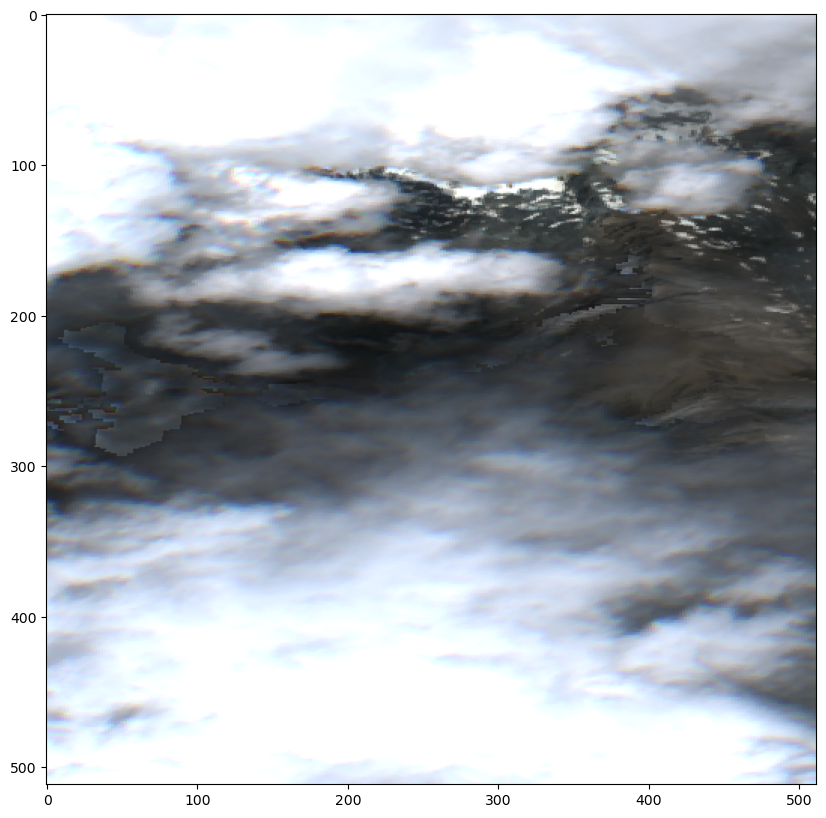

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)

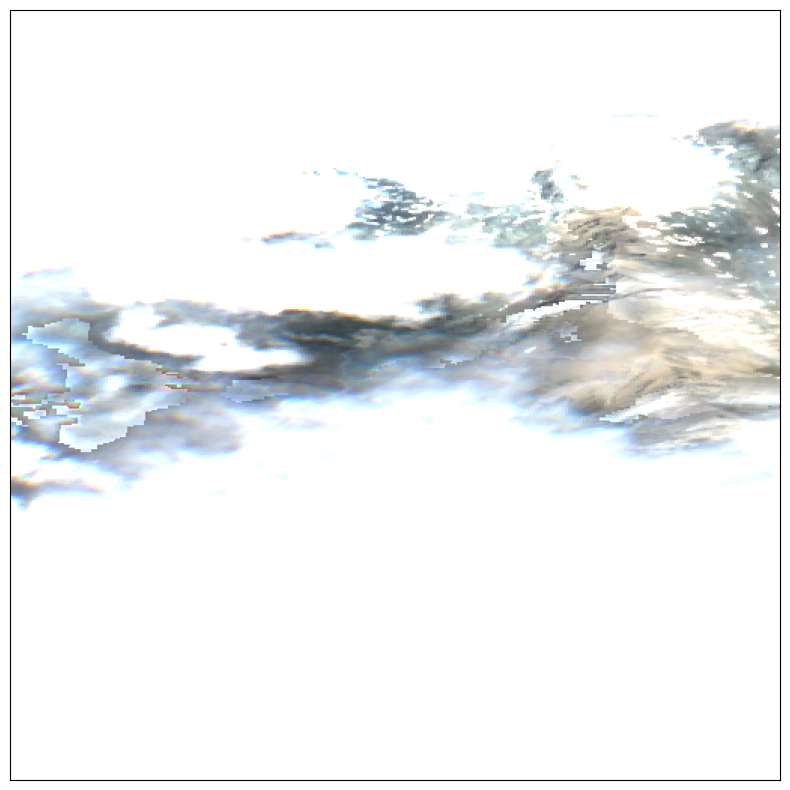

In [33]:
# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [36]:
evalscript_dem = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""

In [ ]:
evalscript_dem = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""
dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM.define_from("dem", service_url=config.sh_base_url),
            time_interval=("2024-06-12", "2025-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=(1024, 1024),  # Use size instead, OR use resolution as tuple below
    # resolution=(5, 5),  # Alternative: specify resolution as (x, y) tuple
    config=config,
)
dem_data = dem_request.get_data()

ValueError: Data collection definition is already taken by DataCollection.DEM. Two different DataCollection enums cannot have the same definition.

In [34]:
plot_image(dem_data[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=0)

NameError: name 'dem_data' is not defined